In [1]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from config import settings
from data import SQLRepository
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
connection = sqlite3.connect(database = settings.db_name, check_same_thread = False)
repo = SQLRepository(connection=connection)

print("repo type:", type(repo))
print("repo.connection type:", type(repo.connection))

repo type: <class 'data.SQLRepository'>
repo.connection type: <class 'sqlite3.Connection'>


In [3]:
df_ambuja = repo.read_table(table_name="AMBUJACEM.BSE", limit = 2500)

print("df_ambuja type:", type(df_ambuja))
print("df_ambuja shape:", df_ambuja.shape)
df_ambuja.head()

df_ambuja type: <class 'pandas.core.frame.DataFrame'>
df_ambuja shape: (2500, 5)


,open,high,low,close,volume
date,,,,,
2025-03-28,543.50,551.80,536.65,537.95,123925.0
2025-03-27,531.25,545.60,527.05,543.05,67658.0
2025-03-26,520.65,537.75,520.00,531.80,115731.0
2025-03-25,524.05,538.50,518.30,520.40,243213.0
2025-03-24,517.00,520.45,510.40,518.95,227903.0


In [4]:
def wrangle_data(ticker, n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df = repo.read_table(table_name=ticker, limit = n_observations + 1)

    # Sort DataFrame ascending by date

    df.sort_index(ascending = True, inplace = True)
    # Create "return" column
    df["return"] = df["close"].pct_change() * 100

    # Return returns
    return df["return"].dropna()

In [5]:
y_ambuja = wrangle_data(ticker="AMBUJACEM.BSE", n_observations=2500)

# Is `y_ambuja` a Series?
assert isinstance(y_ambuja, pd.Series)

# Are there 2500 observations in the Series?
assert len(y_ambuja) == 2500

# Is `y_ambuja` name "return"?
assert y_ambuja.name == "return"

# Does `y_ambuja` have a DatetimeIndex?
assert isinstance(y_ambuja.index, pd.DatetimeIndex)

# Is index sorted ascending?
assert all(y_ambuja.index == y_ambuja.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert y_ambuja.isnull().sum() == 0

y_ambuja.head()

date
2015-02-04    1.449275
2015-02-05   -0.402414
2015-02-06    0.282828
2015-02-09   -0.805802
2015-02-10    1.462226
Name: return, dtype: float64

In [6]:
y_suzlon = wrangle_data(ticker = "SUZLON.BSE", n_observations = 2500)

print("y_suzlon type:", type(y_suzlon))
print("y_suzlon shape:", y_suzlon.shape)
y_suzlon.head()

y_suzlon type: <class 'pandas.core.series.Series'>
y_suzlon shape: (2500,)


date
2015-02-18    16.775599
2015-02-19    -6.529851
2015-02-20     2.195609
2015-02-23    -1.367188
2015-02-24     3.762376
Name: return, dtype: float64

## explore

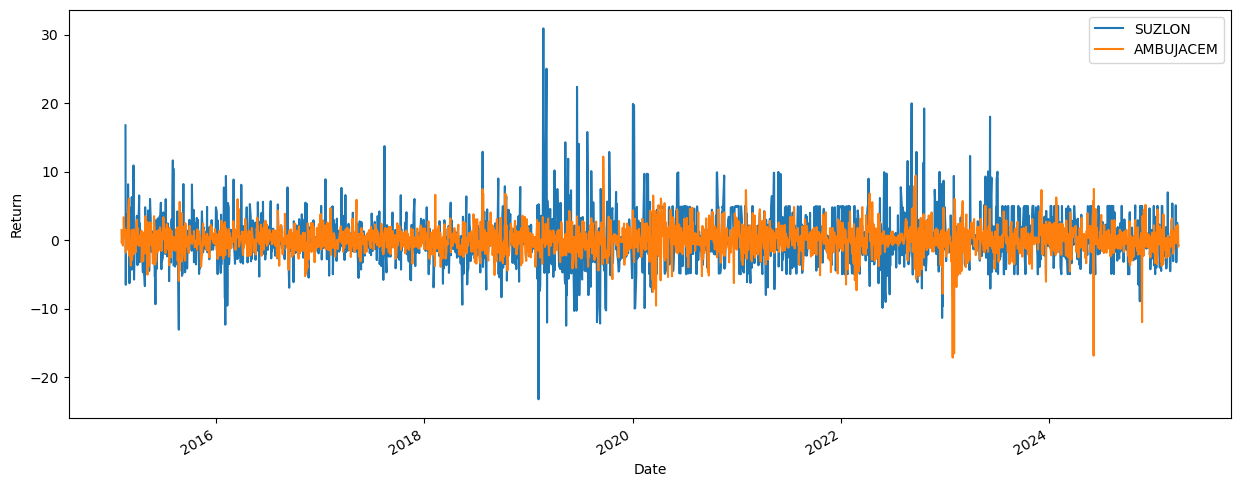

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for `df_suzlon` and `df_ambuja`
y_suzlon.plot(ax=ax, label="SUZLON")
y_ambuja.plot(ax=ax, label="AMBUJACEM")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

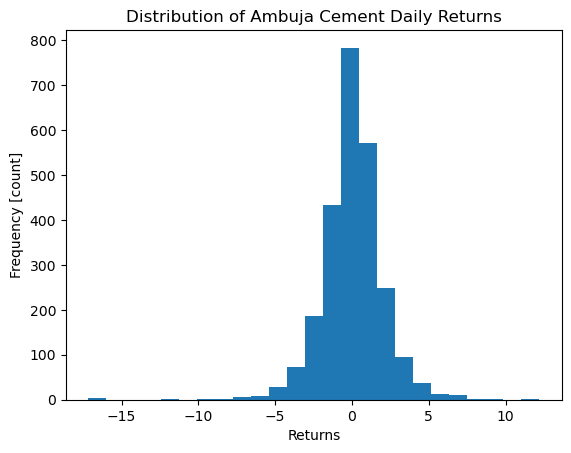

In [8]:
# Create histogram of `y_ambuja`, 25 bins

plt.hist(y_ambuja, bins = 25)
# Add axis labels
plt.xlabel("Returns")
plt.ylabel("Frequency [count]")
# Add title
plt.title("Distribution of Ambuja Cement Daily Returns");

This is a familiar shape! It turns out that returns follow an almost normal distribution, centered on 0. Volatility is the measure of the spread of these returns around the mean. In other words, volatility in finance is the same thing at standard deviation in statistics.

Let's start by measuring the daily volatility of our two stocks. Since our data frequency is also daily, this will be exactly the same as calculating the standard deviation.

In [9]:
suzlon_daily_volatility = y_suzlon.std()
ambuja_daily_volatility = y_ambuja.std()

print("Suzlon Daily Volatility:", suzlon_daily_volatility)
print("Ambuja Daily Volatility:", ambuja_daily_volatility)

Suzlon Daily Volatility: 3.721515211801494
Ambuja Daily Volatility: 1.9963358428743605


In [10]:
suzlon_annual_volatility = suzlon_daily_volatility * np.sqrt(255)
ambuja_annual_volatility = ambuja_daily_volatility * np.sqrt(255)

print("Suzlon Annual Volatility:", suzlon_annual_volatility)
print("Ambuja Annual Volatility:", ambuja_annual_volatility)

Suzlon Annual Volatility: 59.42783224446125
Ambuja Annual Volatility: 31.878926948282704


In [11]:
ambuja_rolling_50d_volatility = y_ambuja.rolling(window = 50).std().dropna()

print("rolling_50d_volatility type:", type(ambuja_rolling_50d_volatility))
print("rolling_50d_volatility shape:", ambuja_rolling_50d_volatility.shape)
ambuja_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (2451,)


date
2015-04-21    1.831112
2015-04-22    1.826096
2015-04-23    1.845692
2015-04-24    1.856588
2015-04-27    1.869092
Name: return, dtype: float64

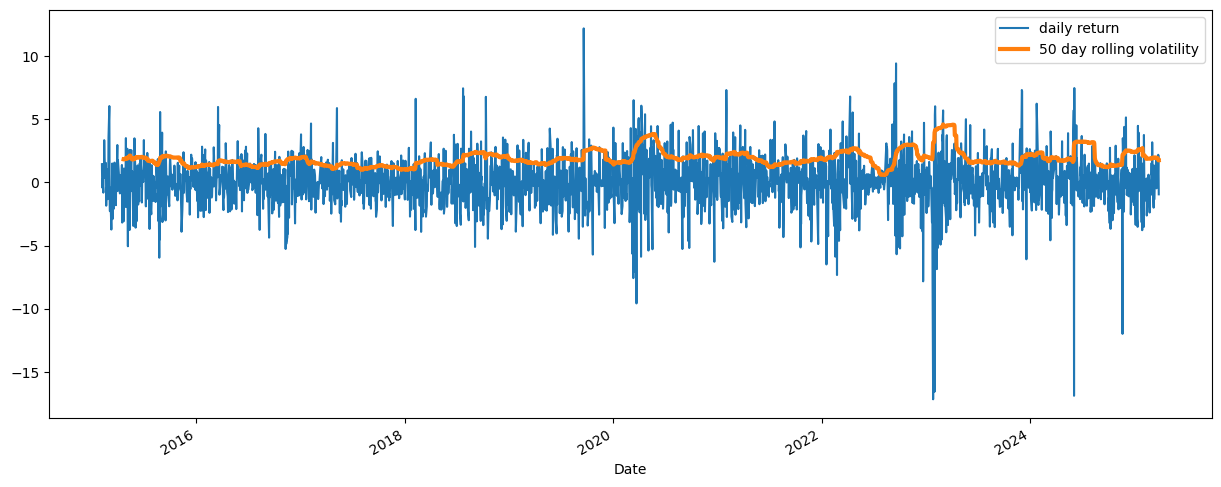

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja`
y_ambuja.plot(ax=ax, label = "daily return")

# Plot `ambuja_rolling_50d_volatility`
ambuja_rolling_50d_volatility.plot(ax=ax, label = "50 day rolling volatility", linewidth = 3)

# Add x-axis label
plt.xlabel("Date")

# Add legend
plt.legend();

Here we can see that volatility goes up when the returns change drastically — either up or down. For instance, we can see a big increase in volatility in May 2020, when there were several days of large negative returns. We can also see volatility go down in August 2022, when there are only small day-to-day changes in returns.

This plot reveals a problem. We want to use returns to see if high volatility on one day is associated with high volatility on the following day. But high volatility is caused by large changes in returns, which can be either positive or negative. How can we assess negative and positive numbers together without them canceling each other out? One solution is to take the absolute value of the numbers, which is what we do to calculate performance metrics like mean absolute error. The other solution, which is more common in this context, is to square all the values.

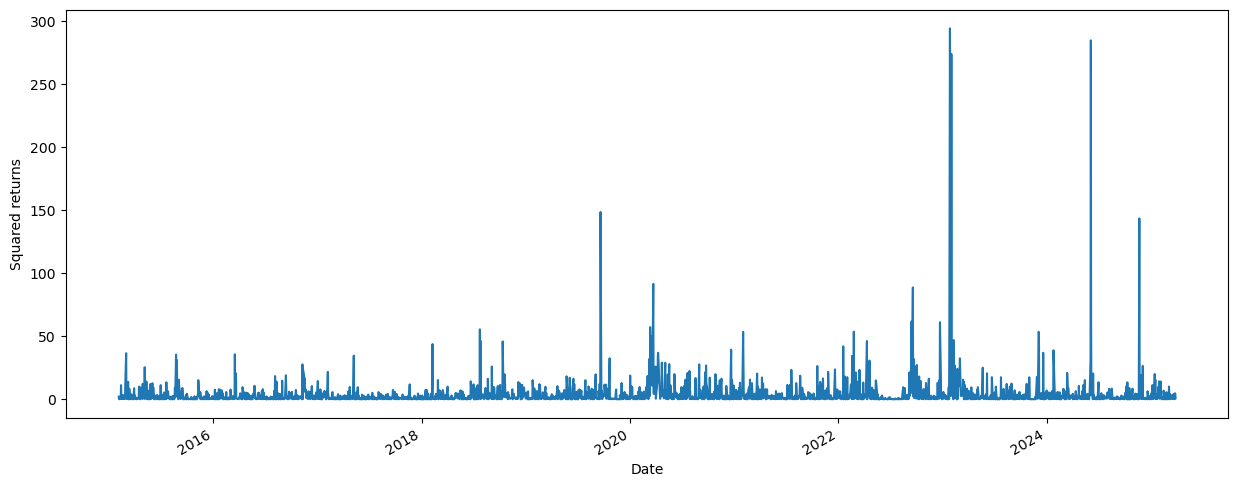

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y_ambuja ** 2).plot(ax=ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared returns");


Perfect! Now it's much easier to see that (1) we have periods of high and low volatility, and (2) high volatility days tend to cluster together. This is a perfect situation to use a GARCH model.

A GARCH model is sort of like the ARMA model we learned about in Lesson 3.4. It has a p parameter handling correlations at prior time steps and a q parameter for dealing with "shock" events. It also uses the notion of lag. To see how many lags we should have in our model, we should create an ACF and PACF plot — but using the squared returns.

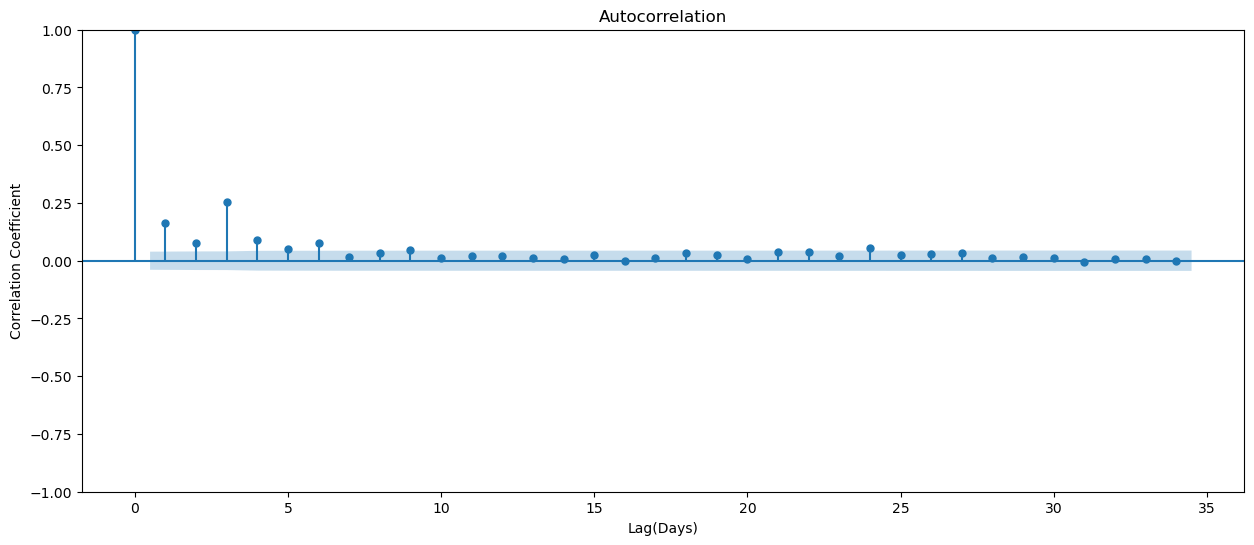

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_ambuja**2, ax=ax)

# Add axis labels
plt.xlabel("Lag(Days)")
plt.ylabel("Correlation Coefficient");

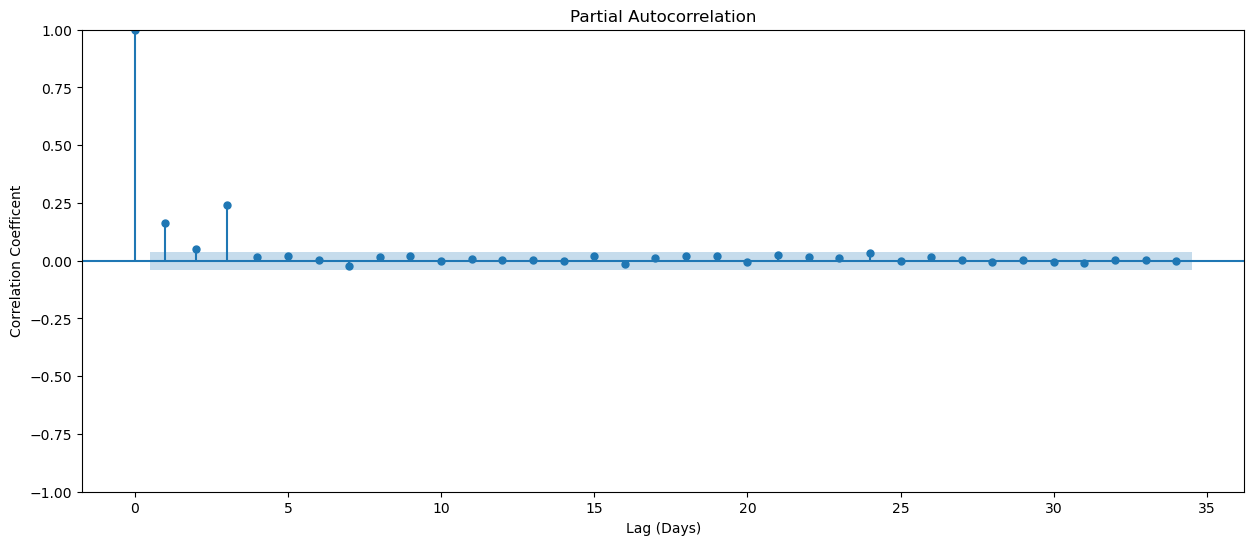

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_ambuja ** 2, ax=ax)

# Add axis labels
plt.xlabel("Lag (Days)")
plt.ylabel("Correlation Coefficent");

In our PACF, it looks like a lag of 3 would be a good starting point.

Normally, at this point in the model building process, we would split our data into training and test sets, and then set a baseline. Not this time. This is because our model's input and its output are two different measurements. We'll use returns to train our model, but we want it to predict volatility. If we created a test set, it wouldn't give us the "true values" that we'd need to assess our model's performance. So this time, we'll skip right to iterating.

Split
The last thing we need to do before building our model is to create a training set. Note that we won't create a test set here. Rather, we'll use all of y_ambuja to conduct walk-forward validation after we've built our model.

In [16]:
cutoff_test = round(len(y_ambuja) * 0.8)
y_ambuja_train = y_ambuja.iloc[:cutoff_test]

print("y_ambuja_train type:", type(y_ambuja_train))
print("y_ambuja_train shape:", y_ambuja_train.shape)
y_ambuja_train.tail()

y_ambuja_train type: <class 'pandas.core.series.Series'>
y_ambuja_train shape: (2000,)


date
2023-03-09   -1.862007
2023-03-10   -1.663418
2023-03-13   -2.775208
2023-03-14   -3.941824
2023-03-15    3.282864
Name: return, dtype: float64

In [17]:
# Build and train model
model = arch_model(
    y_ambuja_train,
    p = 1,
    q = 1,
    rescale = False
).fit(disp = 0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4062.36
Distribution:                  Normal   AIC:                           8132.73
Method:            Maximum Likelihood   BIC:                           8155.13
                                        No. Observations:                 2000
Date:                Tue, Apr 01 2025   Df Residuals:                     1999
Time:                        04:20:40   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0703  3.877e-02      1.813  6.984e-02 [-5.700e-03,  0.146]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2378      0.127      1.867  6.184e-02 [-1.179e-02,  0.487]
alpha[1]       0.1193  3.957e-02      3.016  2.559e-03  [4.179e-02,  0.197]
beta[1]        0.8227  6.351e-02     12.955  2.204e-38    [  0.698,  0.947]
===========================================================================

Covariance estimator: robust
"""

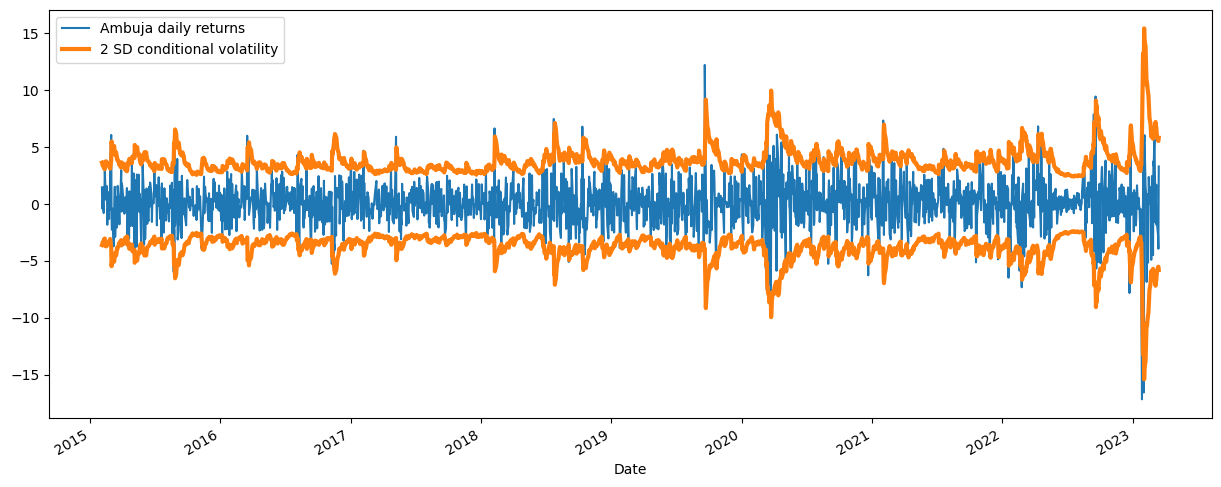

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
y_ambuja_train.plot(ax=ax, label = "Ambuja daily returns")

# Plot conditional volatility * 2
(model.conditional_volatility * 2).plot(ax=ax, label = "2 SD conditional volatility", color = "C1", linewidth = 3)

# Plot conditional volatility * -2
(model.conditional_volatility * -2).rename().plot(ax=ax, color = "C1", linewidth = 3)

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

In [19]:
model.conditional_volatility.head()

date
2015-02-04    1.809940
2015-02-05    1.777608
2015-02-06    1.692391
2015-02-09    1.612337
2015-02-10    1.571046
Name: cond_vol, dtype: float64

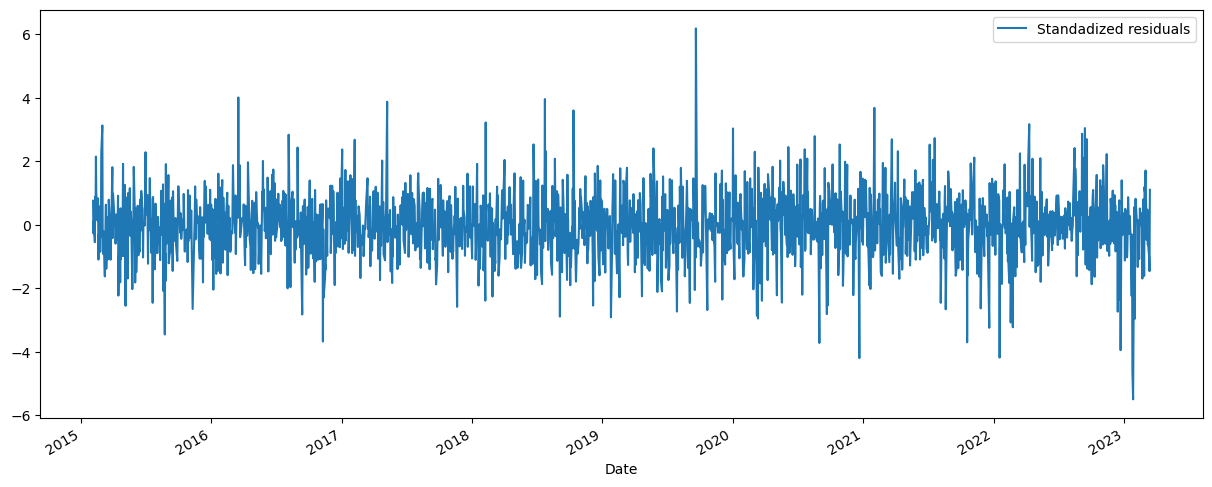

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label = "Standadized residuals")

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

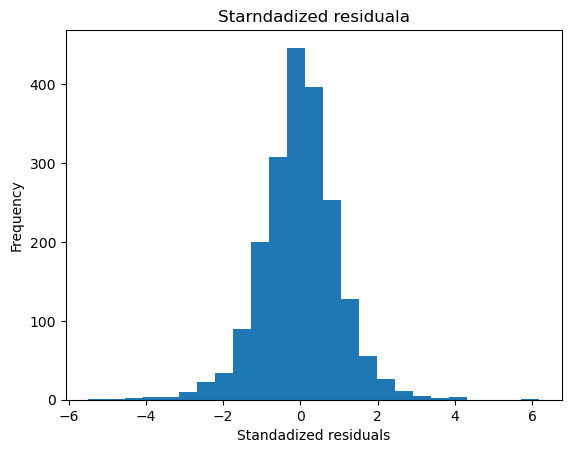

In [21]:
# Create histogram of standardized residuals, 25 bins

plt.hist(model.std_resid, bins = 25)
# Add axis labels
plt.xlabel("Standadized residuals")
plt.ylabel("Frequency")

# Add title
plt.title("Starndadized residuala");

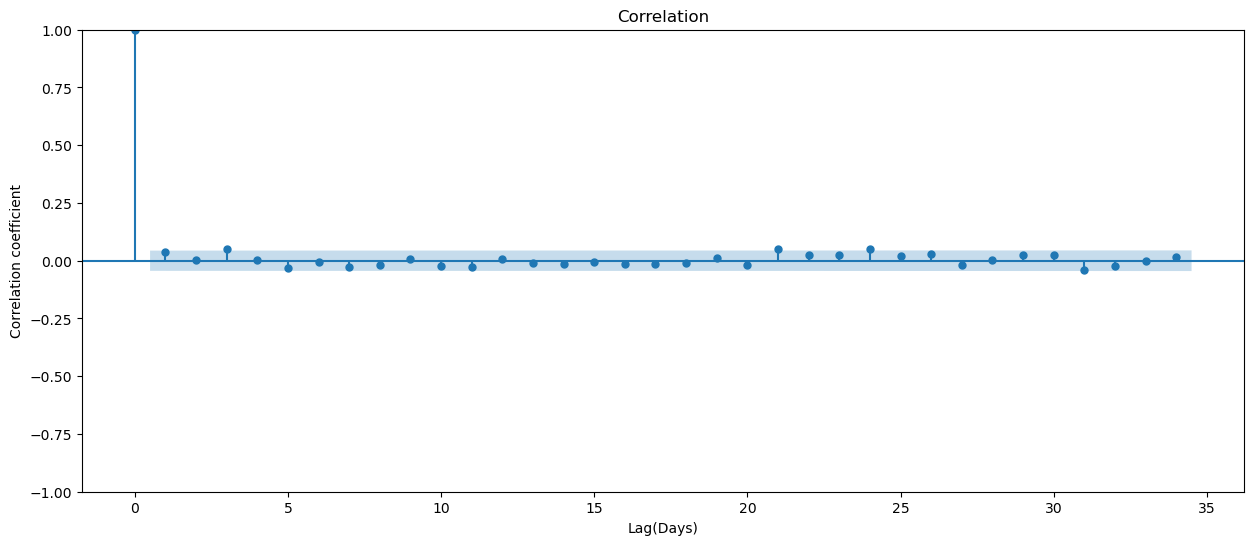

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid ** 2, ax=ax)

# Add axis labels
plt.ylabel("Correlation coefficient")
plt.xlabel("Lag(Days)")
plt.title("Correlation");

In [23]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y_ambuja) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y_ambuja.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p = 1, q = 1, rescale = False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon = 1, reindex = False).variance.iloc[0,0] ** 0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y_ambuja.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (500,)


date
2023-03-16    2.896655
2023-03-17    2.960747
2023-03-20    2.725715
2023-03-21    2.789328
2023-03-22    2.618681
dtype: float64

In [24]:
def predict_volatility_wfv(data):
    # Create empty list to hold predictions
    predictions = []
    
    # Calculate size of test data (20%)
    test_size = int(len(data) * 0.2)
    
    # Walk forward
    for i in range(test_size):
        # Create test data
        y_train = data.iloc[: -(test_size - i)]
    
        # Train model
        model = arch_model(y_train, p = 1, q = 1, rescale = False).fit(disp=0)
    
        # Generate next prediction (volatility, not variance)
        next_pred = model.forecast(horizon = 1, reindex = False).variance.iloc[0,0] ** 0.5
    
        # Append prediction to list
        predictions.append(next_pred)
    
    # Create Series from predictions list
    y_test_wfv = pd.Series(predictions, index=y_ambuja.tail(test_size).index)
    
    print("y_test_wfv type:", type(y_test_wfv))
    print("y_test_wfv shape:", y_test_wfv.shape)
    return y_test_wfv.head()

In [25]:
predict_volatility_wfv(y_ambuja)

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (500,)


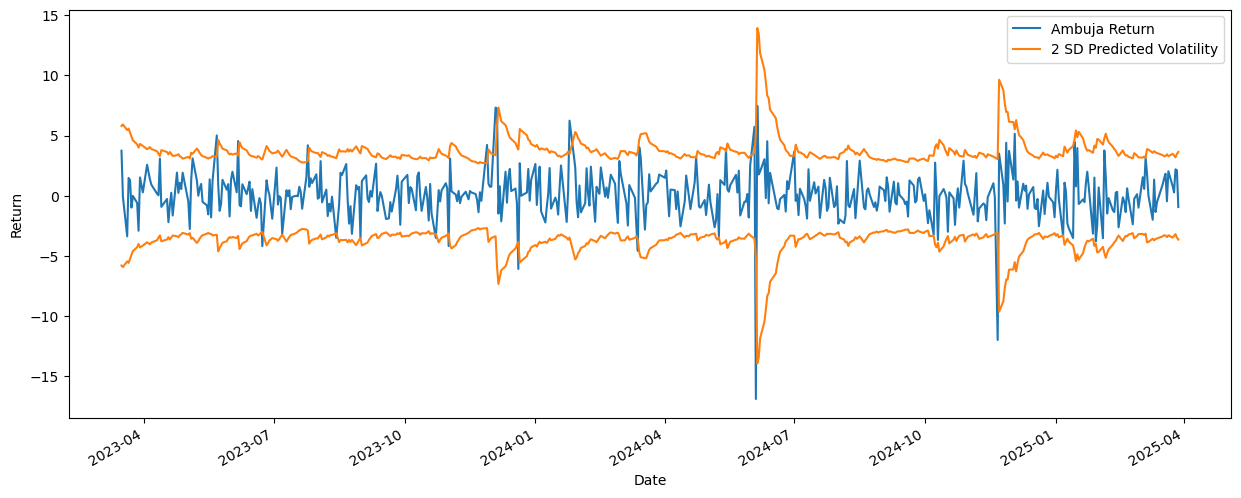

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y_ambuja.tail(test_size).plot(ax=ax, label="Ambuja Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

In [ ]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days = 1)

    # Create date range
    prediction_dates = pd.bdate_range(start = start, periods = prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]

    # Extract predictions from DataFrame, get square root

    data = prediction.values.flatten() ** 0.5
    # Combine `data` and `prediction_index` into Series

    prediction_formatted = pd.Series(data, index = prediction_index)
    # Return Series as dictionary
    return prediction_formatted.to_dict()

In [ ]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted